## Import de kaggle

Ejecutar toddas las celdas para importar el dataset desde Kaggle

In [ ]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f80411e3ad3d17e46fe318cb89bb41489dcc61615d720a07eb93288579e0d78c
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle

In [ ]:
import json

data = {'username':'alexposchenriederutn','key':'268c780c7d8bcda17b0b749ce018fc7a'}
path = '/root/.kaggle/kaggle.json'
with open(path, 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 61.1MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s] 


In [ ]:
! mkdir train
! unzip chest-xray-pneumonia.zip -d train

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: train/chest_xray/tr

## Procesamiento del dataset

### Import libraries

In [ ]:
!pip3 install ann_visualizer
from ann_visualizer.visualize import ann_viz

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp37-none-any.whl size=4168 sha256=717ed204ef8f192f06820b421a043f921a765fbb528c55513ffd467a744a7da0
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from ann_visualizer.visualize import ann_viz
from tensorflow import keras
from tensorflow.keras import Input, layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.layers.core import Activation, Dropout, Flatten, Dense, Reshape
from keras import backend as K
from keras import layers
from keras.models import load_model
from keras.metrics import Recall, Precision

import os
import numpy as np
import pandas as pd

from random import randint
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Configuración y otros

In [ ]:
main_dir = "/content/train/chest_xray/chest_xray/"
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

nb_train_samples = 5216
nb_validation_samples = 16
epochs = 20
batch_size = 16

In [ ]:
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5218
length of pneumonia cases in training set: 3876
length of normal cases in training set: 1342


(1858, 2090)
(1858, 2090, 3)


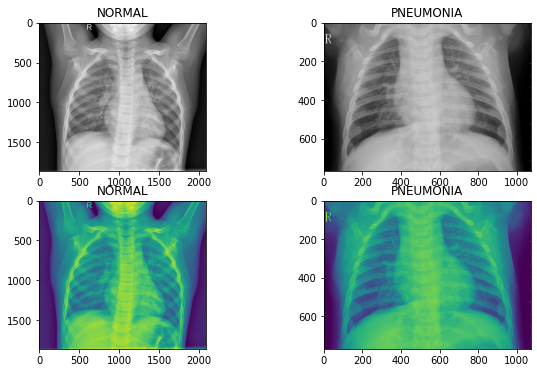

In [ ]:
# Quick look to the images 

img_name = 'IM-0115-0001.jpeg'
img_normal = load_img('/content/train/chest_xray/chest_xray/train/NORMAL/' + img_name)

img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = load_img('/content/train/chest_xray/chest_xray/train/PNEUMONIA/' + img_name_1)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(img_normal)
axs[0][0].set_title("NORMAL")
axs[0][1].imshow(img_pneumonia)
axs[0][1].set_title("PNEUMONIA");

# Grayscale
img_normal_gs = img_normal.convert('L')
img_pneumonia_gs = img_pneumonia.convert('L')
axs[1][0].imshow(img_normal_gs)
axs[1][0].set_title("NORMAL")
axs[1][1].imshow(img_pneumonia_gs)
axs[1][1].set_title("PNEUMONIA")

print(np.asarray(img_normal_gs).shape)
print(np.asarray(img_normal).shape)

The actual sizes of the photos are so high that I set them to size 180x180.

In [ ]:
img_height, img_width  = 180, 180


if K.image_data_format() == 'channels_first':
    #input_shape = (3, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    #input_shape = (img_width, img_height, 3) Cambio la shape para que sea grayscale
    input_shape = (img_width, img_height, 1)
    
input_shape

(180, 180, 1)

### Generar sets Train, test, y validation

In [ ]:
# Se comenta la DataAugmentation
#train_datagen = ImageDataGenerator(
#    rescale=1. / 255,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True)


train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    # Convierte las imágenes a grayscale
    color_mode="grayscale",
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    # Convierte las imágenes a grayscale
    color_mode="grayscale",
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    # Convierte las imágenes a grayscale
    color_mode="grayscale",
    class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Image batch size: 518400
Label batch size: 16


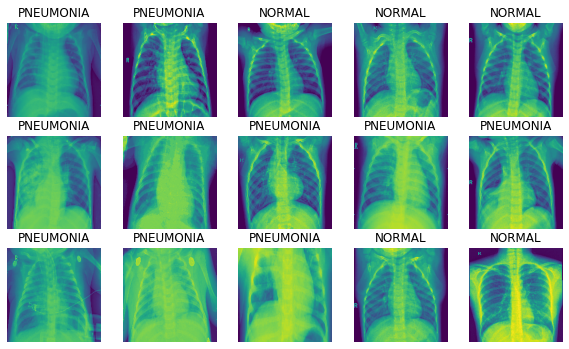

In [ ]:
# Mostrar imágenes
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        ## Agrego el squeeze para que funque el grayscale
        plt.imshow(image_batch[n].squeeze(axis=2))
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)
print("Image batch size:",image_batch.size)
print("Label batch size:",label_batch.size)

## Construcción




### CNN de referencia

In [ ]:
### CNN ejemplo

modelCNN = Sequential()
modelCNN.add(InputLayer(input_shape=input_shape))
modelCNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Flatten())
modelCNN.add(Dense(64, activation="relu"))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(1))
modelCNN.add(Activation('sigmoid'))

modelCNN.summary()
model = modelCNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 180, 180, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)            

### ANN - Nuestro TP


In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Flatten())
model.add( Dense(20, activation='relu'))
model.add( Dense(15, activation='relu'))
#model.add( Dense(10, activation='relu'))
#model.add( Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
#model.add(Activation('sigmoid'))
model.summary()
model.output_shape
# ann_viz(model, view=True, title="My first neural network",filename="ANN1") # No funca con la capa Reshape

### Cargar/Guardar modelo de archivo



In [ ]:
# Cargar modelo
# Para usar, subir los archivos al entorno de colab o conectar la carpeta de drive
path = '/content/modelo_20_62%.h5'
log_path = '/content/modelo_20_62%.log'
model = load_model(path)
# Cargar historial de entrenamiento
model_history = pd.read_csv(log_path, sep=',', engine='python')


In [ ]:
# Guardar modelo
from datetime import datetime

time = datetime.now()
dt_string = time.strftime("%Y%m%d%H%M%S")
fileName = "model_" + dt_string + ".h5"
fileName = "modelo_20_15_82%.h5"

model.save(fileName) 

## Entrenamiento y demás


### Compilación

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'mse',Recall(), Precision()]) # Min squared error, para plotear despues

In [ ]:
# Define the callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
# EarlyStopping, para que el entrenamiento pare si ve que no mejora la función de coste tras determinados epochs
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4) 
csv_logger = CSVLogger('training.log', separator=',', append=False) 
callbacks_list = [early_stop,csv_logger]#, reduce_lr]  

### Entrenamiento

In [ ]:
model_hist = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

model_history = model_hist.history

### Evaluación

In [ ]:
# Evaluación
scores = model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test MSE: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))
print("Test Precision: %.2f%%"%(scores[4] * 100))


39/39 [==============================] - 6s 142ms/step - loss: 0.5321 - accuracy: 0.8109 - mse: 0.1539 - recall_4: 0.9641 - precision_4: 0.7833
Loss of the model: 0.53
Test Accuracy: 81.09%
Test MSE: 15.39%
Test Recall: 96.41%
Test Precision: 78.33%


### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
# Está deprecado pero todavía funciona
predictions = model.predict_classes(test_generator)
classes = test_generator.classes
conf_matrix = confusion_matrix(classes,predictions)
conf_matrix

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[ 56, 178],
       [ 88, 302]])

### Hacer predicción manual

predicted: PNEUMONIA


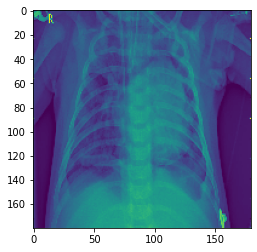

In [ ]:
def predict_image(filename):
    img_rgb = load_img(filename, target_size=(img_height, img_width))
    img = img_rgb.convert('L')
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,180,180,1)
    #modelTest = load_model('chestxray_model_3.h5')
    modelTest = model
    prediction = modelTest.predict(image)
    plt.imshow(img)
    if(prediction[0] > 0.5):
        print("predicted: PNEUMONIA")
    else:
        print("predicted: NORMAL")


predict_image("/content/train/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg")
#predict_image("/content/train/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

### Graficos de entrenamiento


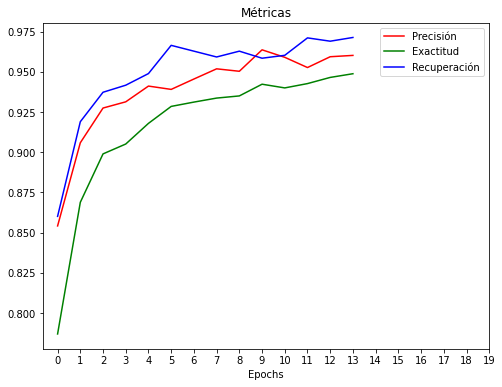

In [ ]:
plt.figure(0)  
plt.plot(model_history['precision_4'],'r')  
plt.plot(model_history['accuracy'],'g')
plt.plot(model_history['recall_4'],'b')
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Epochs")  
plt.title("Métricas")  
plt.legend(['Precisión','Exactitud','Recuperación'])

plt.show()  